# Exploratory data analysis and feature extraction with Python

Using **data visualization**, **feature engineering** and **feature selection** to make a simple **logistic regression** look powerful!

[Pedro Marcelino](http://pmarcelino.com/) - April 2018

Other Kernels: [Comprehensive data exploration in Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

---

# 0. Belfast, an earlier incubator

Incubators are companies that support the creation of startups and their first years of activity. They are important because they help entrepreneurs solve some issues commonly associated with running a business, such as workspace, training, and seed funding.

Our engineering masterpiece also needs a starting point. In this section, we start the assemblage of our work by importing some libraries and general functions.

## Imports

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Put this when it's called
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

## Functions

In [4]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [5]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [6]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

---

### Data prep

In [14]:
# Import data
df = pd.read_csv('../input/train.csv')
df_raw = df.copy()  # Save original data set, just in case.

# Drop Cabin
df.drop('Cabin', axis=1, inplace=True)

# Fill missing values in Age with a specific value
value = 1000
df['Age'].fillna(1000, inplace=True)

# Delete observations without Embarked
df.drop(df[pd.isnull(df['Embarked'])].index, inplace=True)  # Get index of points where Embarked is null

# Drop PassengerId
df.drop('PassengerId', axis=1, inplace=True)

# Define categorical variables
df['Sex'] = pd.Categorical(df['Sex'])
df['Embarked'] = pd.Categorical(df['Embarked'])

# Create Family feature
df['FamilySize'] = df['SibSp'] + df['Parch']

# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)

# Drop Name and Ticket
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)

# Transform categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)  # To avoid dummy trap

Extra: [What is the 'dummy variable trap'?](http://www.algosome.com/articles/dummy-variable-trap-regression.html)

### Test/Train split

In [17]:
# Create data set to train data imputation methods
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Model

In [60]:
# Fit logistic regression
logreg = LogisticRegression(max_iter=500, tol=0.0001)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 1.4.3.  Assessing model performance: Learning and Validation curves

In [61]:
# Model performance
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.786 +/- 0.031


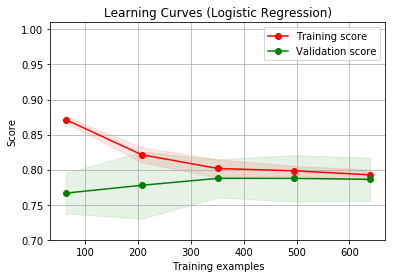

In [62]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

* **overfitting**, model fits the training set, but not the validation set. 
    * furthermore, the model is not able to generalize to unseen data. 
    * Troubleshoot: 
        * reduce the complexity
        * collect more data.
* **underfitting**, model fits neither training nor validations sets. 
    * Troubleshoot: 
        * Improve the model (e.g., tune hyperparameters) 
        * Improve the data quality (e.g., change features).
        * **note** more data is not helpful, since training doesn't work!

**Learning curves** help diagnose these problems
* **overfitting**: the learning curve shows a gap between the training and validation scores.     
* **underfitting**: the learning curves will converge to a low score value. 

Discussion of our results:
* The model doesn't overfit. As we can see, the curves converge and no gap between the training and the validation score exists in the last points of the curve.
* The model underfits. Our final score is about 0.786. Although our model does better predictions than a [flip-a-coin strategy](https://en.wikipedia.org/wiki/Flipism), it is still far from being an 'intelligent' model. For now, it's just an 'artificial' model.

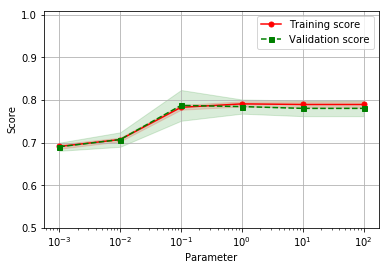

In [63]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train, y=y_train, param_name=param_name,
                      ylim=(0.5, 1.01), param_range=param_range);

**Validation curves** help the performance of our model by tuning the hyperparameters.
* see how the **model parameter** affects the training and validation scores. 
    * choose a different parameter value to improve the model.
* a gap between the training and validation scores suggests **overfitting**
* no gap but low score suggests **underfitting**

Discussion of our results:
* The figure shows that there is no huge difference in model's performance as far as we choose a C value of $10^{-1}$ or higher. Note that in a logistic regression, C is the only model parameter that we can change [(see scikit-learn documentation)](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). 